# Анализ и группировка типов транспортных средств

В этом ноутбуке мы проведем анализ и группировку типов транспортных средств, используя методы обработки естественного языка и машинного обучения, с учетом специфики русского языка.

In [55]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from pymystem3 import Mystem

# Скачиваем необходимые ресурсы NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Инициализируем стеммер и список стоп-слов
stemmer = SnowballStemmer("russian")
russian_stopwords = set(stopwords.words('russian'))
mystem = Mystem()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeymuravskiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sergeymuravskiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Шаг 1: Загрузка и подготовка данных

In [56]:
# Шаг 1: Загрузка и подготовка данных
df = pd.read_csv('input_table.csv', sep=';')
print(df.head())
print(f"Всего записей: {len(df)}")

   Id     Version  TypeId                      Name  IsActive
0   1  4023045752       1         Грузовой-бортовой      True
1   2  4023045752       1                     Пикап      True
2   3  4023045752       3      Бронированный фургон      True
3   4  4023045752       3  Грузопассажирский фургон      True
4   5  4023045752       3     Изотермический фургон      True
Всего записей: 1474


## Шаг 2: Предобработка текста

In [57]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Замена дефиса на пробел
    text = text.replace('-', ' ')
    
    # Удаление пунктуации и специальных символов, кроме пробелов
    text = re.sub(r'[^\w\s]', '', text)
    
    # Нормализация пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Лемматизация
    lemmas = mystem.lemmatize(text)
    text = ''.join(lemmas)
    
    # Удаление стоп-слов
    words = text.split()
    words = [word for word in words if word not in russian_stopwords]
    text = ' '.join(words)
    
    return text

# Применяем функцию к данным
df['Processed_Name'] = df['Name'].apply(preprocess_text)
print(df[['Name', 'Processed_Name']].head())

                       Name            Processed_Name
0         Грузовой-бортовой         грузовой бортовой
1                     Пикап                     пикап
2      Бронированный фургон      бронированный фургон
3  Грузопассажирский фургон  грузопассажирский фургон
4     Изотермический фургон     изотермический фургон


## Шаг 3: Векторизация текста

In [58]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=r'\b\w+\b')
X = vectorizer.fit_transform(df['Processed_Name'])
print(f"Размерность векторного пространства: {X.shape}")

Размерность векторного пространства: (1474, 2175)


## Шаг 4: Оптимизация количества кластеров

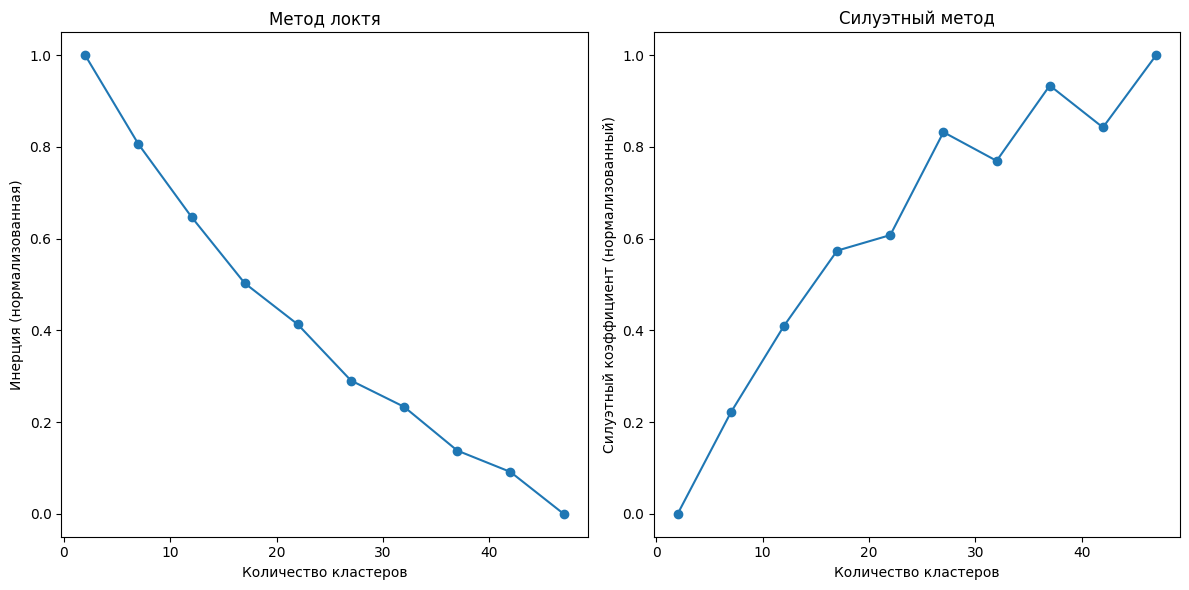

Оптимальное количество кластеров: 47


In [59]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def optimize_clusters(X, max_clusters=50, step=5):
    inertias = []
    silhouette_scores = []
    n_clusters_range = range(2, max_clusters + 1, step)
    
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Нормализация значений для сравнения
    inertias = np.array(inertias)
    silhouette_scores = np.array(silhouette_scores)
    inertias = (inertias - inertias.min()) / (inertias.max() - inertias.min())
    silhouette_scores = (silhouette_scores - silhouette_scores.min()) / (silhouette_scores.max() - silhouette_scores.min())
    
    # Комбинированный показатель
    combined_score = silhouette_scores - inertias
    optimal_clusters = n_clusters_range[np.argmax(combined_score)]
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(n_clusters_range, inertias, marker='o')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция (нормализованная)')
    plt.title('Метод локтя')
    
    plt.subplot(1, 2, 2)
    plt.plot(n_clusters_range, silhouette_scores, marker='o')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Силуэтный коэффициент (нормализованный)')
    plt.title('Силуэтный метод')
    
    plt.tight_layout()
    plt.show()
    
    return optimal_clusters

# Использование функции
optimal_clusters = optimize_clusters(X)
print(f"Оптимальное количество кластеров: {optimal_clusters}")

# Кластеризация с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

## Шаг 5: Кластеризация с оптимальным количеством кластеров

In [60]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

print(df[['Name', 'Processed_Name', 'Cluster']].head(10))

                         Name              Processed_Name  Cluster
0           Грузовой-бортовой           грузовой бортовой       21
1                       Пикап                       пикап       15
2        Бронированный фургон        бронированный фургон        8
3    Грузопассажирский фургон    грузопассажирский фургон        8
4       Изотермический фургон       изотермический фургон        5
5         Промтоварный фургон         промтоварный фургон        8
6              Хлебный фургон              хлебный фургон        8
7  Цельнометаллический фургон  цельнометаллический фургон        8
8             Седельный тягач             седельный тягач       31
9                       Багги                       багги       15


## Шаг 6: Анализ результатов и автоматическое именование кластеров

In [61]:
def get_top_words(vector, feature_names, top_n=5):
    importance = np.squeeze(np.asarray(vector.sum(axis=0)))
    top_indices = importance.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_indices]

feature_names = vectorizer.get_feature_names_out()
cluster_names = {}
cluster_data = []

for cluster in range(optimal_clusters):
    print(f"\nКластер {cluster}:")
    cluster_samples = df[df['Cluster'] == cluster]['Name'].tolist()
    print("Примеры:", cluster_samples[:5])
    
    cluster_texts = df[df['Cluster'] == cluster]['Processed_Name']
    cluster_vector = vectorizer.transform(cluster_texts)
    top_words = get_top_words(cluster_vector, feature_names)
    print("Топ-5 слов:", top_words)
    
    cluster_name = " ".join(top_words[:2])
    cluster_names[cluster] = cluster_name
    print("Название кластера:", cluster_name)
    
    # Собираем данные для сохранения
    cluster_data.append({
        'Cluster': cluster,
        'Cluster_Name': cluster_name,
        'Top_Words': ", ".join(top_words),
        'Sample_Names': ", ".join(cluster_samples[:5]),
        'Count': len(cluster_samples)
    })

# Создаем DataFrame с информацией о кластерах
cluster_info_df = pd.DataFrame(cluster_data)

# Добавляем названия кластеров в основной DataFrame
df['Cluster_Name'] = df['Cluster'].map(cluster_names)

# Сохраняем основной DataFrame с результатами кластеризации
df[['Name', 'Processed_Name', 'Cluster', 'Cluster_Name']].to_csv('clustered_vehicles.csv', index=False)
print("Результаты кластеризации сохранены в файл 'clustered_vehicles.csv'")

# Сохраняем информацию о кластерах
cluster_info_df.to_csv('cluster_info.csv', index=False)
print("Информация о кластерах сохранена в файл 'cluster_info.csv'")

# Выводим сводную информацию
print("\nРаспределение по кластерам:")
print(df['Cluster_Name'].value_counts())

print("\nПример классификации:")
sample = df[['Name', 'Cluster_Name']].sample(n=10)
print(sample)


Кластер 0:
Примеры: ['Фронтальный вилочный автопогрузчик', 'Вилочный электропогрузчик', 'Вилочный автопогрузчик', 'Автопогрузчик вилочный', 'Погрузчик вилочный']
Топ-5 слов: ['вилочный', 'погрузчик', 'автопогрузчик', 'вилочный погрузчик', 'автопогрузчик вилочный']
Название кластера: вилочный погрузчик

Кластер 1:
Примеры: ['Эвакуатор', 'Эвакуатор с КМУ', 'Прицеп эвакуатор', 'Специальный эвакуатор с КМУ', 'Автомобиль эвакуатор']
Топ-5 слов: ['эвакуатор', 'специальный эвакуатор', 'эвакуатор кму', 'специальный', 'кму']
Название кластера: эвакуатор специальный эвакуатор

Кластер 2:
Примеры: ['Полуприцеп самосвальный', 'Полуприцеп-автовоз', 'Полуприцеп-зерновоз', 'Полуприцеп-лесовоз', 'Полуприцеп-панелевоз']
Топ-5 слов: ['полуприцеп', 'тент', 'полуприцеп тент', 'бортовой полуприцеп', 'специализированный полуприцеп']
Название кластера: полуприцеп тент

Кластер 3:
Примеры: ['Фронтальный погрузчик', 'Погрузчик фронтальный', 'Погрузчик одноковшовый фронтальный', 'Погрузчик одноковшовый колесны

# Шаг 7: Визуализация результатов

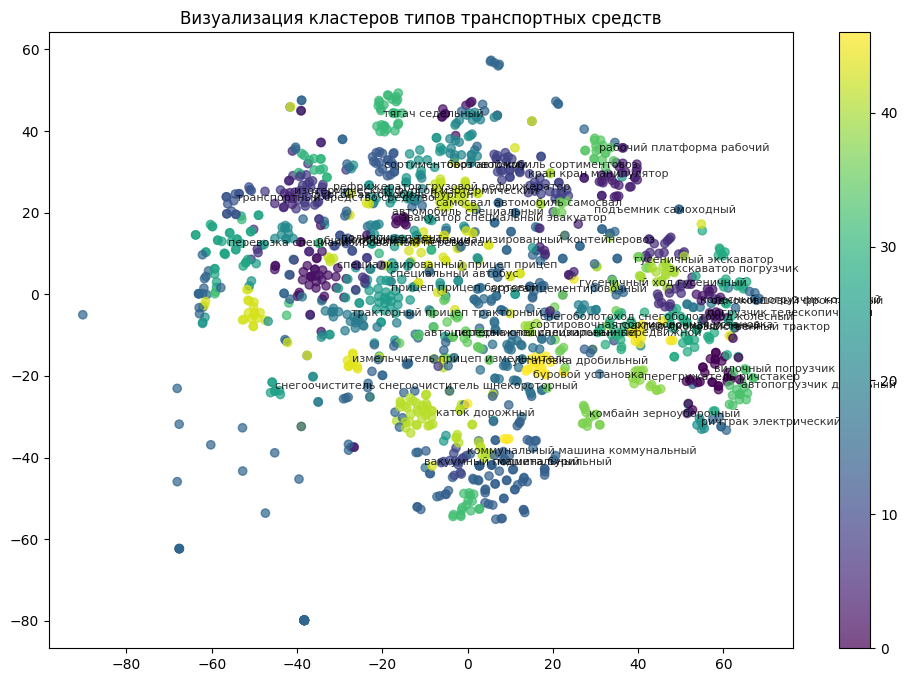

Результаты сохранены в файл 'clustered_vehicles.csv'

Распределение по кластерам:
Cluster_Name
автоцистерна специализированный                   235
машина бурильный                                   80
специальный автобус                                73
прицеп прицеп бортовой                             67
погрузчик телескопический                          56
автомобиль специальный                             55
каток дорожный                                     53
полуприцеп тент                                    52
кран кран манипулятор                              43
подъемник самоходный                               43
бортовой кму                                       41
установка дробильный                               40
перевозка специализированный перевозка             35
самосвал автомобиль самосвал                       34
вилочный погрузчик                                 32
фургон автомобиль фургон                           32
экскаватор погрузчик                     

In [62]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('Визуализация кластеров типов транспортных средств')

# Добавляем подписи кластеров
for cluster, name in cluster_names.items():
    centroid = np.mean(X_tsne[df['Cluster'] == cluster], axis=0)
    plt.annotate(name, centroid, fontsize=8, alpha=0.8)

plt.show()

# Сохраняем результаты
df[['Name', 'Cluster', 'Cluster_Name']].to_csv('clustered_vehicles.csv', index=False)
print("Результаты сохранены в файл 'clustered_vehicles.csv'")

# Дополнительная статистика
print("\nРаспределение по кластерам:")
print(df['Cluster_Name'].value_counts())

print("\nПример классификации:")
sample = df[['Name', 'Cluster_Name']].sample(n=10)
print(sample)